# mamba
## 获取数据

In [1]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open     High       Low     Close    Volume
Date                                                       
2018-01-02   52.6510   53.799   52.6510   53.6720  31753540
2018-01-03   53.6965   54.805   53.6715   54.5760  31305800
2018-01-04   54.8545   55.204   54.7130   54.8000  26049960
2018-01-05   55.1725   55.679   55.0900   55.5145  30238600
2018-01-08   55.5500   55.958   55.5000   55.7105  24626920
...              ...      ...       ...       ...       ...
2023-12-22  140.7700  141.990  140.7100  141.4900  26532199
2023-12-26  141.5900  142.680  141.1900  141.5200  16780333
2023-12-27  141.5900  142.080  139.8860  140.3700  19628618
2023-12-28  140.7800  141.140  139.7500  140.2300  16045712
2023-12-29  139.6300  140.360  138.7800  139.6900  18733017

[1509 rows x 5 columns]


In [6]:
df.iloc[:,:-1]

,Open,High,Low,Close
Date,,,,
2018-01-02,52.6510,53.799,52.6510,53.6720
2018-01-03,53.6965,54.805,53.6715,54.5760
2018-01-04,54.8545,55.204,54.7130,54.8000
2018-01-05,55.1725,55.679,55.0900,55.5145
2018-01-08,55.5500,55.958,55.5000,55.7105
...,...,...,...,...
2023-12-22,140.7700,141.990,140.7100,141.4900
2023-12-26,141.5900,142.680,141.1900,141.5200
2023-12-27,141.5900,142.080,139.8860,140.3700


In [3]:
import numpy as np
df_da = df.iloc[:,:-2]
print(df_da.shape)
# print(df_ta.mean())
# print(df_ta.std())
# noise = np.random.normal(0, 10, df_ta.shape)

noise = np.random.normal(0, 10, df_da.shape)
noise.shape
# df_da += noise

# print((df_ta+noise).mean())
# print((df_ta+noise).std())


(1509, 3)


(1509, 3)

In [8]:
import numpy as np

mem_his_days=5
per_days=10

# 股票数据
df['label'] = df['Close'].shift(-per_days)
# 加入噪声
df_da = df.iloc[:,:-2]
# noise = np.random.normal(0, 10, df_da.shape)
# df_da += noise

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,:-2])

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)
print(len(X_lately))

(1495, 5, 4)
(1495,)
10


## 制作数据集

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(X_lately))

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 训练数据
batch, length, dim = 64, 5, 4
# noise = np.random.normal(sca_X.mean(), 0.05*sca_X.std(), X_train.shape)
# X_train += noise
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# # 虚拟数据
X_train_tensor = torch.randn(1351,5,4)
y_train_tensor = torch.randn(1351,1)
X_test_tensor = torch.randn(150,5,4)
y_test_tensor = torch.randn(150,1)

# 定义训练集数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True,drop_last=False)

# 定义测试集数据加载器
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([1351, 5, 4])
torch.Size([1351, 1])
torch.Size([150, 5, 4])
torch.Size([150, 1])


## 原始模型

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_mamba import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size,conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x):
        x = self.fc1(x)
        x = self.mamba(x)
        x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(x)
        return x

# 初始化模型
model_mam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                          conv_width=4, expand_factor=2, output_dim=1)
print(model_mam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_mam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 训练模型
losses_mam = []
mse_test_mam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_mam.train()
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape,y_batch.shape)
        y_pred = model_mam(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_mam.append(loss.item())
    # # 评价
    # model_mam.eval()
    # y_pred_batch = y_test_tensor
    # with torch.no_grad():
    #     for inputs, labels in test_loader:
    #         outputs = model_mam(inputs)
    #         y_pred_batch = torch.cat((y_pred_batch,outputs),dim=0)
    # mse = mean_squared_error(y_pred_batch[:y_test_tensor.shape[0]] , y_pred_batch[y_test_tensor.shape[0]:])
    # 评价
    model_mam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_mam(x_test_batch)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    # 打印
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')


SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Epoch [5/10], Loss: 1.7715, 	 Mse:1.0690
Epoch [10/10], Loss: 0.8709, 	 Mse:1.0691


In [10]:
model_mam.mamba.deltaB_u.shape
# model_mam.mamba.Luen_grad.shape
model_mam.mamba.L.shape

torch.Size([64, 16])

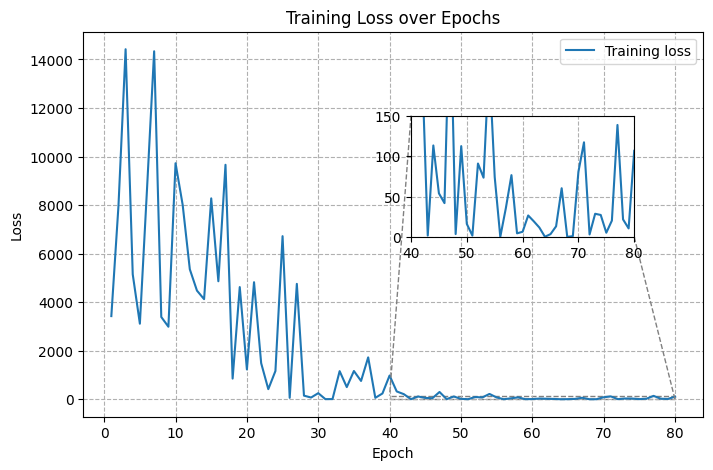

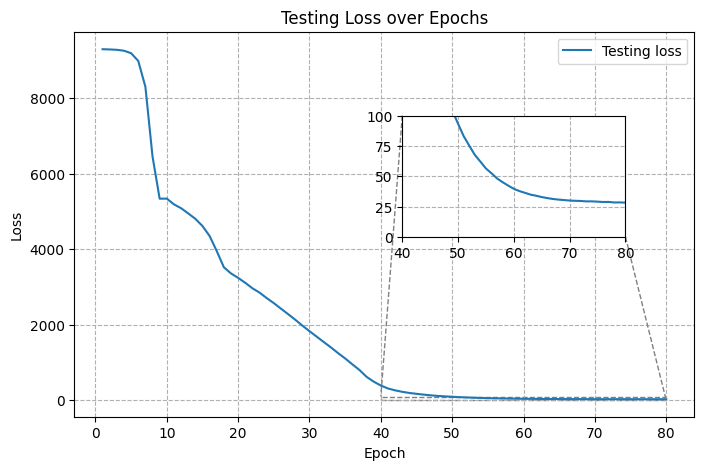

In [19]:
# 绘制 loss 曲线
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y = np.array(losses_mam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 150)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")
plt.show()

# 测试数据
# x = np.linspace(1,num_epochs)
y = np.array(mse_test_mam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 100)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")

plt.show()

### 预测

In [8]:
# 预测误差
from sklearn.metrics import mean_squared_error

model_mam.eval()
with torch.no_grad():
    y_pred = model_mam(X_test_tensor)
# print(f"Predicted shape: {y_pred.shape}")
mse = mean_squared_error(y_pred , y_test)
print(mse)



29.86809178819266


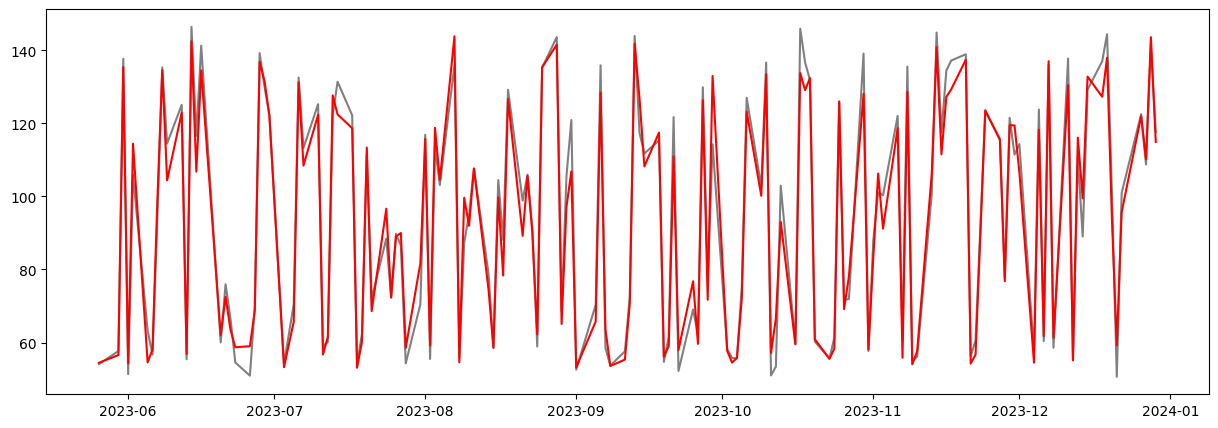

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

### 结果评价

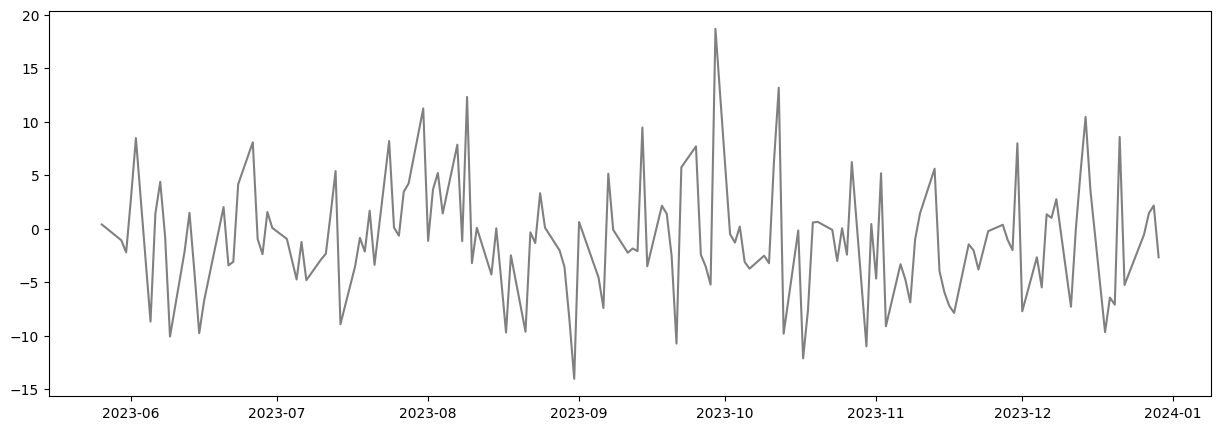

In [10]:
# 计算残差
y_e = y_pred[:,0]-y_test
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_e,color='gray',label='price')
plt.show()

In [12]:
# 对残差纯随机性检验
import numpy as np
import statsmodels.api as sm

data = y_e
# 进行 LBQ 检验，设置 lags 参数为需要检验的自相关阶数
lags = 30  # 选择检验的最大自相关阶数
lbq_test = sm.stats.acorr_ljungbox(data, lags=lags)
print(lbq_test)

# lb_stat 越小，残差自相关性越弱
# p 大于 0.05 才支持 纯随机 假设

      lb_stat  lb_pvalue
1    0.138724   0.709553
2    0.179289   0.914256
3    0.955209   0.812088
4    2.728051   0.604315
5    2.952218   0.707352
6    5.112881   0.529419
7    6.553473   0.476802
8    6.770426   0.561593
9    7.292787   0.606665
10  11.833874   0.296329
11  16.869375   0.111799
12  16.878870   0.154211
13  17.098386   0.194845
14  17.891803   0.211753
15  18.079858   0.258490
16  18.266551   0.308521
17  22.415025   0.169280
18  24.895908   0.127810
19  24.897389   0.163948
20  25.016989   0.200782
21  27.454744   0.156303
22  27.595910   0.189462
23  27.714744   0.226761
24  27.855592   0.266178
25  28.301942   0.294142
26  36.948033   0.075563
27  37.931242   0.078955
28  39.234854   0.077219
29  39.380859   0.094581
30  41.196224   0.083697


## karma
### L size(1xn) in scan

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_1xn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 80
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        grad_mem = latest_gradient[:,2]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    with torch.no_grad():
        y_pred1 = model_kam(X_test_tensor[:64],latest_gradient)
        y_pred2 = model_kam(X_test_tensor[64:128],latest_gradient)
        y_pred3 = model_kam(torch.cat((X_test_tensor[128:],X_test_tensor[:42]),dim=0),latest_gradient)
    # print(f"Predicted shape: {y_pred.shape}")
    y_pred = torch.cat((y_pred1,y_pred2,y_pred3),dim=0)[:150]
    mse = mean_squared_error(y_pred , y_test_tensor)
    mse_test_kam.append(mse)

    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)


RuntimeError: einsum(): subscript a has size 64 for operand 1 which does not broadcast with previously seen size 6

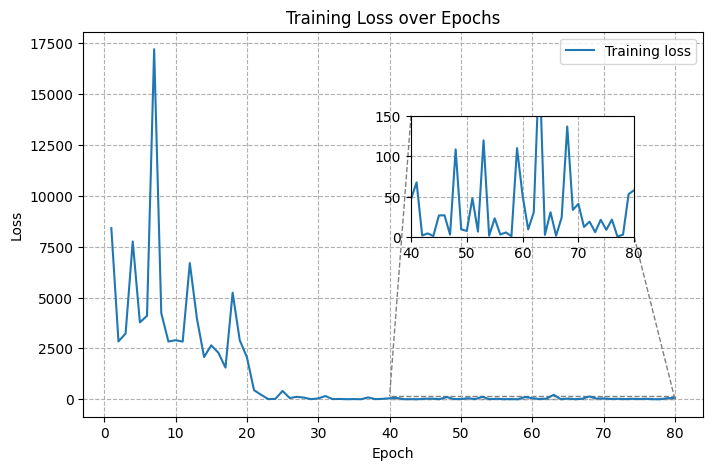

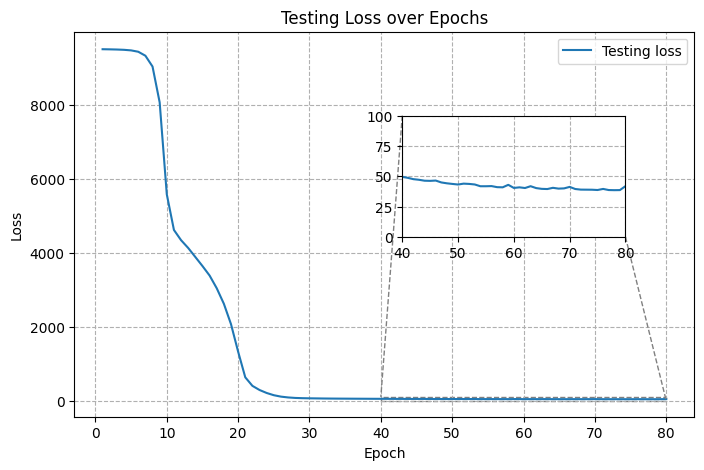

In [7]:
# 绘制 loss 曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y = np.array(losses_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 150)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")
plt.show()

# 测试数据
# x = np.linspace(1,num_epochs)
y = np.array(mse_test_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 100)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")


plt.show()

In [5]:
x.shape,y.shape

((20,), (20,))

In [11]:
model.mamba.L

Parameter containing:
tensor([[ 0.0098, -0.0085,  0.0040,  0.0017, -0.0002,  0.0002, -0.0017, -0.0049,
         -0.0058,  0.0031, -0.0071, -0.0062,  0.0026,  0.0021,  0.0096,  0.0070]],
       requires_grad=True)

### L size(bxn) in scan

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # # 评价
    # model_kam.eval()
    # y_pred_batch = y_test_tensor
    # with torch.no_grad():
    #     for inputs, labels in test_loader:
    #         outputs = model_kam(inputs,latest_gradient)
    #         y_pred_batch = torch.cat((y_pred_batch,outputs),dim=0)
    # mse = mean_squared_error(y_pred_batch[:y_test_tensor.shape[0]] , y_pred_batch[y_test_tensor.shape[0]:])

    # 评价
    model_kam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)


    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Epoch [5/10], Loss: 0.7333, 	 Mse:0.9908
Epoch [10/10], Loss: 1.5605, 	 Mse:0.9932


In [56]:
# print(x_batch.shape,latest_gradient.shape)
# print(X_test_tensor[:64].shape,latest_gradient.shape)
model_kam.mamba.delta.shape
latest_gradient.shape
# model_kam.mamba.As
# model_kam.mamba.L.shape
# x_batch.shape
# X_test_tensor[i*batch:(i+1)*batch].shape
# model_kam.mamba.L.shape
# outputs.shape

torch.Size([150, 5, 64])

In [ ]:
# 绘制 loss 曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y = np.array(losses_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 150)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")
plt.show()

# 测试数据
# x = np.linspace(1,num_epochs)
y = np.array(mse_test_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 100)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")


plt.show()

### deltaL size(bxn) in scan

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Epoch [5/10], Loss: 0.4056, 	 Mse:0.8920
Epoch [10/10], Loss: 2.0600, 	 Mse:0.8933


In [52]:
model_kam.mamba.delta.shape
latest_gradient.shape
# model_kam.mamba.As
# model_kam.mamba.L.shape
# x_batch.shape
# X_test_tensor[i*batch:(i+1)*batch].shape
# model_kam.mamba.L.shape
# outputs.shape

torch.Size([64, 5, 64])

In [33]:
import einops
print(model_kam.mamba.deltaA.shape)
print(x_batch.shape[0],', 64, 16')
print(model_kam.mamba.deltaB_u.shape)
# print(latest_gradient.shape)
# print(model_kam.mamba.L.shape)
# X_test_tensor[i*batch:(i+1)*batch].shape

b,l,n=model_kam.mamba.deltaB_u.shape[0],5,16
grad = latest_gradient[:b]
delta = model_kam.mamba.delta
L = einops.repeat(model_kam.mamba.L,'b n -> b l n',l=l)[:b] # 也可直接设置L(b l n)
deltaL_grad = einops.einsum(delta, L, grad, 'b l d_in, b l n, b l d_in -> b l d_in n')
print(deltaL_grad.shape)

torch.Size([7, 5, 64, 16])
7 , 64, 16
torch.Size([7, 5, 64, 16])
torch.Size([7, 5, 64, 16])


### 加入当前步grad

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_deltaLsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch)
        loss = criterion(y_pred, y_batch)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        x_test_batch.requires_grad = True
        y_pred_batch = model_kam(x_test_batch)
        loss = criterion(y_pred_batch, y_test_batch)
        # hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    # # 评价
    # model_kam.eval()
    # y_pred = []
    # for x_test_batch,y_test_batch in test_loader:
    #     with torch.no_grad():
    #         y_pred_batch = model_kam(x_test_batch,latest_gradient)
    #         y_pred.append(y_pred_batch)
    # y_pred = torch.cat(tuple(y_pred),dim=0)
    # mse = mean_squared_error(y_pred , y_test_tensor)

    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Epoch [5/10], Loss: 0.9198, 	 Mse:1.0313
Epoch [10/10], Loss: 0.9125, 	 Mse:1.0276


In [6]:
print(model_kam.mamba.L.shape)
print(latest_gradient.shape)

model_kam.mamba.deltaB_u.shape

torch.Size([64, 16])
torch.Size([64, 5, 64])


torch.Size([7, 5, 64, 16])

In [5]:
import einops
# print(model_kam.mamba.deltaA.shape)
# print(x_batch.shape[0],', 64, 16')
# print(model_kam.mamba.deltaB_u.shape)
# print(latest_gradient.shape)
# print(model_kam.mamba.L.shape)
# X_test_tensor[i*batch:(i+1)*batch].shape

b,l,n=model_kam.mamba.deltaB_u.shape[0],5,16
grad = latest_gradient[:b]
delta = model_kam.mamba.delta
L = einops.repeat(model_kam.mamba.L,'b n -> b l n',l=l)[:b] # 也可直接设置L(b l n)
deltaL_grad = einops.einsum(L, grad, 'b l n, b l d_in -> b l d_in n')
print(L.shape)
print(grad.shape)
print(deltaL_grad.shape)

torch.Size([7, 5, 16])
torch.Size([7, 5, 64])
torch.Size([7, 5, 64, 16])


### deltaL size(1xn) in scan

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_deltaLsize_1xn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# np.random.seed(6)
torch.manual_seed(3)
# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape,end='')
        # print(latest_gradient.shape)
        # print(latest_gradient.grad)
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)
        
        # print(latest_gradient)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        # print(model_kam.mamba.out_proj.weight)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # latest_gradient = model_kam.mamba.intermediate_output
        # print(model_kam.mamba.out_proj.weight)

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred_list = []
    y_test_list = []
    for x_test_batch,y_test_batch in test_loader:
        y_test_list.append(y_test_batch)
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred_list.append(y_pred_batch)
    y_pred_lists = torch.cat(tuple(y_pred_list),dim=0)
    y_test_lists = torch.cat(tuple(y_test_list),dim=0)
    mse = mean_squared_error(y_pred_lists , y_test_lists)
    mse_test_kam.append(mse)

    # hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Epoch [5/10], Loss: 0.6198, 	 Mse:1.0369
Epoch [10/10], Loss: 0.5520, 	 Mse:1.0318


In [4]:
import einops
print(model_kam.mamba.deltaA.shape)
print(x_batch.shape[0],', 64, 16')
print(model_kam.mamba.deltaB_u.shape)
# print(latest_gradient.shape)
print(model_kam.mamba.L.shape)
# X_test_tensor[i*batch:(i+1)*batch].shape

l,n=5,16
b = min(x_batch.shape[0],latest_gradient.shape[0])
grad = latest_gradient[:b]
delta = model_kam.mamba.delta[:b]
Li = model_kam.mamba.L
L = einops.repeat(Li,'n -> b l n',l=l,b=b) # 也可直接设置L(b l n)
deltaL_grad = einops.einsum(delta, L, grad, 'b l d_in, b l n, b l d_in -> b l d_in n')
print(deltaL_grad.shape)

torch.Size([22, 5, 64, 16])
7 , 64, 16
torch.Size([22, 5, 64, 16])
torch.Size([16])
torch.Size([7, 5, 64, 16])


In [8]:
latest_gradient.shape

torch.Size([64, 5, 64])

In [6]:
150%64

22

### deltaL size(bln) in scan

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_1xn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape,end='')
        # print(latest_gradient.shape)
        # print(latest_gradient.grad)
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)
        
        # print(latest_gradient)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        # print(model_kam.mamba.out_proj.weight)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # latest_gradient = model_kam.mamba.intermediate_output
        # print(model_kam.mamba.out_proj.weight)

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred_list = []
    y_test_list = []
    for x_test_batch,y_test_batch in test_loader:
        y_test_list.append(y_test_batch)
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred_list.append(y_pred_batch)
    y_pred_lists = torch.cat(tuple(y_pred_list),dim=0)
    y_test_lists = torch.cat(tuple(y_test_list),dim=0)
    mse = mean_squared_error(y_pred_lists , y_test_lists)
    mse_test_kam.append(mse)

    # hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
hook_handle.remove()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Epoch [5/10], Loss: 1.0407, 	 Mse:1.0094
Epoch [10/10], Loss: 0.5122, 	 Mse:1.0066


In [13]:
print(y_pred_lists.T)
print(mse_test_kam)

tensor([[ 0.0085,  0.0526,  0.0244,  0.0459,  0.0230,  0.0293,  0.0285,  0.0275,
          0.0078,  0.0135,  0.0144,  0.0214,  0.0312,  0.0287,  0.0232,  0.0345,
          0.0200,  0.0518,  0.0509,  0.0272,  0.0361, -0.0073,  0.0207,  0.0323,
          0.0105,  0.0480,  0.0404,  0.0288,  0.0030,  0.0330,  0.0262,  0.0238,
          0.0340,  0.0161,  0.0254,  0.0473,  0.0378,  0.0409,  0.0201,  0.0280,
          0.0411,  0.0134,  0.0371,  0.0346,  0.0401,  0.0421,  0.0132, -0.0215,
          0.0296,  0.0135,  0.0336,  0.0271,  0.0244,  0.0415,  0.0244,  0.0673,
          0.0400,  0.0237,  0.0221,  0.0339,  0.0231,  0.0219,  0.0045,  0.0033,
          0.0190,  0.0310,  0.0376,  0.0454,  0.0400,  0.0275,  0.0145,  0.0656,
          0.0113,  0.0122,  0.0291, -0.0076,  0.0088,  0.0163,  0.0293,  0.0299,
          0.0150,  0.0224,  0.0578,  0.0325,  0.0555,  0.0203,  0.0286,  0.0371,
          0.0287,  0.0187,  0.0330,  0.0218,  0.0341,  0.0447,  0.0590,  0.0504,
          0.0141,  0.0414,  

# relu

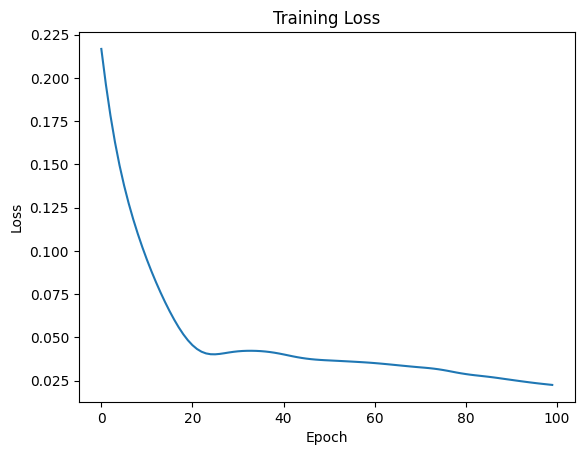

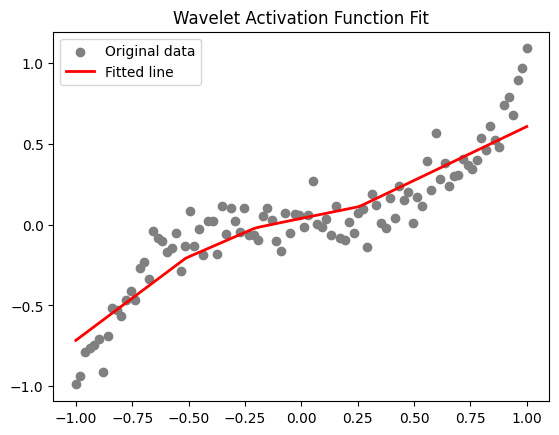

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 定义Haar小波函数
def haar_wavelet(x):
    # Haar小波函数的定义
    condition = (x >= 0) & (x < 1)
    return torch.where(condition, 1.0, -1.0)

# 定义高斯径向基函数
def Daubechies(x):
    y = np.cos(1.75 * x) * np.exp(-x**2 / 2.0)
    return y

# 定义一个简单的神经网络模型
class WaveletNet(torch.nn.Module):
    def __init__(self):
        super(WaveletNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)  # 输入特征为1，输出特征为10
        self.fc2 = torch.nn.Linear(10, 1)  # 输入特征为10，输出特征为1

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)  # 这里使用ReLU作为隐层激活函数，也可以替换为小波基函数
        # x = haar_wavelet(x)
        x = self.fc2(x)
        return x

# 生成一些示例数据
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(3) + 0.1 * torch.randn(x.size())

# 实例化模型和优化器
model = WaveletNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# 训练模型
losses = []
num_epochs = 100
for epoch in range(num_epochs):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 绘制损失曲线
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 绘制拟合曲线
model.eval()
with torch.no_grad():
    y_pred = model(x)
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Original data')
plt.plot(x.numpy(), y_pred.numpy(), color='red', linewidth=2, label='Fitted line')
plt.legend()
plt.title('Wavelet Activation Function Fit')
plt.show()


In [4]:
x = np.linspace(-1,1,40)
y = x
plt.plot(x,F.relu(x))
plt.grid(True, linestyle='--')
plt.show()


TypeError: relu(): argument 'input' (position 1) must be Tensor, not numpy.ndarray